In [1]:
import plotly as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import datetime 
from plotly.offline import plot




import plotly.tools as plotly_tools
from plotly.graph_objs import *
import plotly.graph_objects as go

import os
import tempfile

from IPython.display import HTML
from chart_studio.plotly import plot, iplot

#os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()
plt.style.use('ggplot')


#os.chdir('/Users/bonaventurapacileo/Documents/IS-DS/VR')
os.getcwd()






/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



'/Users/bonaventurapacileo/Documents/IS-DS/VR'

In [2]:
cols = ['index','scene_index','time','ms_lastline','head_posx',"head_posy","head_posz","head_rotx","head_roty","head_rotz",
        "right_posx","right_posy","right_posz","right_rotx","right_roty","right_rotz",
        "left_posx","left_posy","left_posz","left_rotx","left_roty","left_rotz",]

alldata = pd.read_table('/Users/bonaventurapacileo/Documents/IS-DS/VR/data/monitorData 18-03-2020.txt', sep=',', header=0, names=cols)



In [3]:
alldata.loc[:,'head_posx':] = alldata.loc[:,'head_posx':]/1000

In [4]:
gym = alldata[alldata.scene_index==1]
gym['time'] = pd.to_datetime(gym['time'], format="%H:%M:%S").dt.time
#gym = gym[gym.time >= datetime.time(15,7,37)]

/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
cols = ["head_rotx","head_roty","head_rotz","right_rotx","right_roty","right_rotz",
        "left_rotx","left_roty","left_rotz"]

for col in cols:
    #print(col)
    gym[str(col+"_n")] = gym[col]
    gym.loc[gym[str(col+"_n")]>180,str(col+"_n")] = gym.loc[gym[col]>180,col] - 360

/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
timedelta = pd.to_timedelta(gym.time.astype(str))
diff = timedelta.diff().fillna(pd.Timedelta(seconds=0))/1e9
gym['seconds'] = np.cumsum(diff).astype(int)

/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
timedelta = timedelta.reset_index()


for row in range(1,len(timedelta)):
    timedelta.time[row] = timedelta.time[row - 1] + datetime.timedelta(milliseconds=13)
gym = gym.reset_index()
#gym['time_ms'] = timedelta.time





/Users/bonaventurapacileo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
ms_time = [0]
for row in range(1,len(gym)):
    ms_time.append(ms_time[row-1] + 13)

gym['ms_time'] = ms_time
gym['ms_time'] = gym.ms_time/1000






In [9]:
main_activity = ['w'] #replaced below with row=1

for row in range(1,len(gym)):
    #print(row)
    x = np.abs(gym.head_rotx_n[row]-gym.head_rotx_n[row-1])
    y = np.abs(gym.head_roty_n[row]-gym.head_roty_n[row-1])
    z = np.abs(gym.head_rotz_n[row]-gym.head_rotz_n[row-1])
    
    diff = max(x,y,z)
    
    maskx = diff == np.abs(gym.head_rotx_n[row]-gym.head_rotx_n[row-1])
    masky = diff == np.abs(gym.head_roty_n[row]-gym.head_roty_n[row-1])
    maskz = diff == np.abs(gym.head_rotz_n[row]-gym.head_rotz_n[row-1])
    
    if maskx:
        if gym.head_rotx_n[row]-gym.head_rotx_n[row-1]>=0:
            main_activity.append('FLEX')
        else:
            main_activity.append('EXTE')
 
    elif masky:
        if gym.head_roty_n[row]-gym.head_roty_n[row-1]>=0:
            main_activity.append('RROT')
        else:
            main_activity.append('LROT')
             
    elif maskz:
        if gym.head_rotz_n[row]-gym.head_rotz_n[row-1]>=0:
            main_activity.append('RBEN')
        else:
            main_activity.append('LBEN')
    else:
        print('error at {}'.format(row))

main_activity[0] = main_activity[1]


gym['activity'] = main_activity
    

In [10]:
gym

,level_0,index,scene_index,time,ms_lastline,head_posx,head_posy,head_posz,head_rotx,head_roty,...,head_rotz_n,right_rotx_n,right_roty_n,right_rotz_n,left_rotx_n,left_roty_n,left_rotz_n,seconds,ms_time,activity
0,824,825,1,09:50:38,13,-0.006,1.644,0.018,34.471,4.440,...,-5.263,46.462,-75.452,111.881,58.622,161.740,-126.333,0,0.000,FLEX
1,825,826,1,09:50:38,13,-0.006,1.644,0.018,34.471,4.440,...,-5.263,46.451,-78.964,113.017,60.439,164.839,-115.737,0,0.013,FLEX
2,826,827,1,09:50:38,13,-0.003,1.643,0.018,34.661,5.449,...,-5.038,46.834,-77.765,113.489,60.139,165.253,-115.208,0,0.026,RROT
3,827,828,1,09:50:38,13,-0.001,1.642,0.019,34.934,6.572,...,-4.700,47.104,-78.519,115.688,60.759,165.608,-107.823,0,0.039,RROT
4,828,829,1,09:50:38,13,-0.001,1.642,0.019,34.934,6.572,...,-4.700,47.145,-79.108,116.822,61.262,166.726,-103.322,0,0.052,FLEX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26737,27561,27562,1,09:56:49,13,0.018,1.722,-0.021,353.811,3.994,...,-3.492,17.226,-29.221,-107.972,53.785,39.000,-105.960,371,347.581,EXTE
26738,27562,27563,1,09:56:49,13,0.018,1.722,-0.021,353.727,4.055,...,-3.502,17.262,-28.684,-107.960,53.948,41.416,-104.130,371,347.594,EXTE
26739,27563,27564,1,09:56:49,13,0.018,1.722,-0.021,353.665,4.112,...,-3.489,17.378,-28.650,-108.468,53.918,44.305,-101.741,371,347.607,EXTE
26740,27564,27565,1,09:56:49,13,0.018,1.722,-0.021,353.626,4.167,...,-3.466,16.862,-29.100,-109.396,53.759,46.772,-99.785,371,347.620,RROT


In [11]:
gym_red= gym.loc[:,['activity',"head_rotx_n","head_roty_n","head_rotz_n"]]

gym_dict = {'FLEX':1, 'EXTE':2, 'RROT':3, 'LROT':4, 'RBEN':5, 'LBEN':6}

In [12]:
act_num = []
for row in range(len(gym_red)):
    act_num.append(gym_dict[gym_red.loc[row,'activity']])

gym_red['activity_n'] = act_num

In [13]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1992

In [14]:
df = gym_red

df.shape #26742*5=133,710

(26742, 5)

In [15]:
# what about OVERLAP????
N_TIME_STEPS = 72 ## 1 second
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['head_rotx_n'].values[i: i + N_TIME_STEPS]
    ys = df['head_roty_n'].values[i: i + N_TIME_STEPS]
    zs = df['head_rotz_n'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [16]:
np.array(segments).shape #5,469,120 #133,710


(1334, 3, 72)

In [17]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)


In [19]:
tf.reset_default_graph()
reshaped_segments.shape


(1334, 72, 3)

In [20]:
N_CLASSES = 6
N_HIDDEN_UNITS = 32 #it was 64
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [21]:

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [22]:

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#for i in tf.get_default_graph().get_operations():
    #print(i.name)

In [23]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [34]:
LEARNING_RATE = 0.0025 #original 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [ ]:
N_EPOCHS = 5
BATCH_SIZE = 25
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

In [37]:
sess.close()

In [28]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [29]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

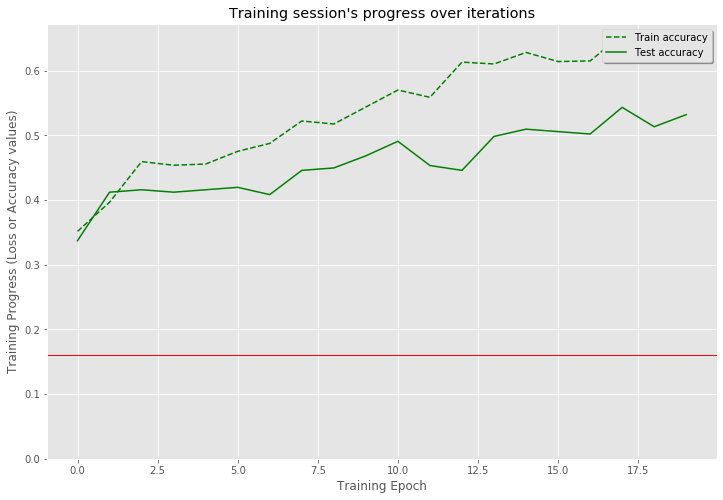

In [30]:
plt.figure(figsize=(12, 8))
#plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
#plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.axhline(y=0.16, linewidth=1, color='r')
plt.show()

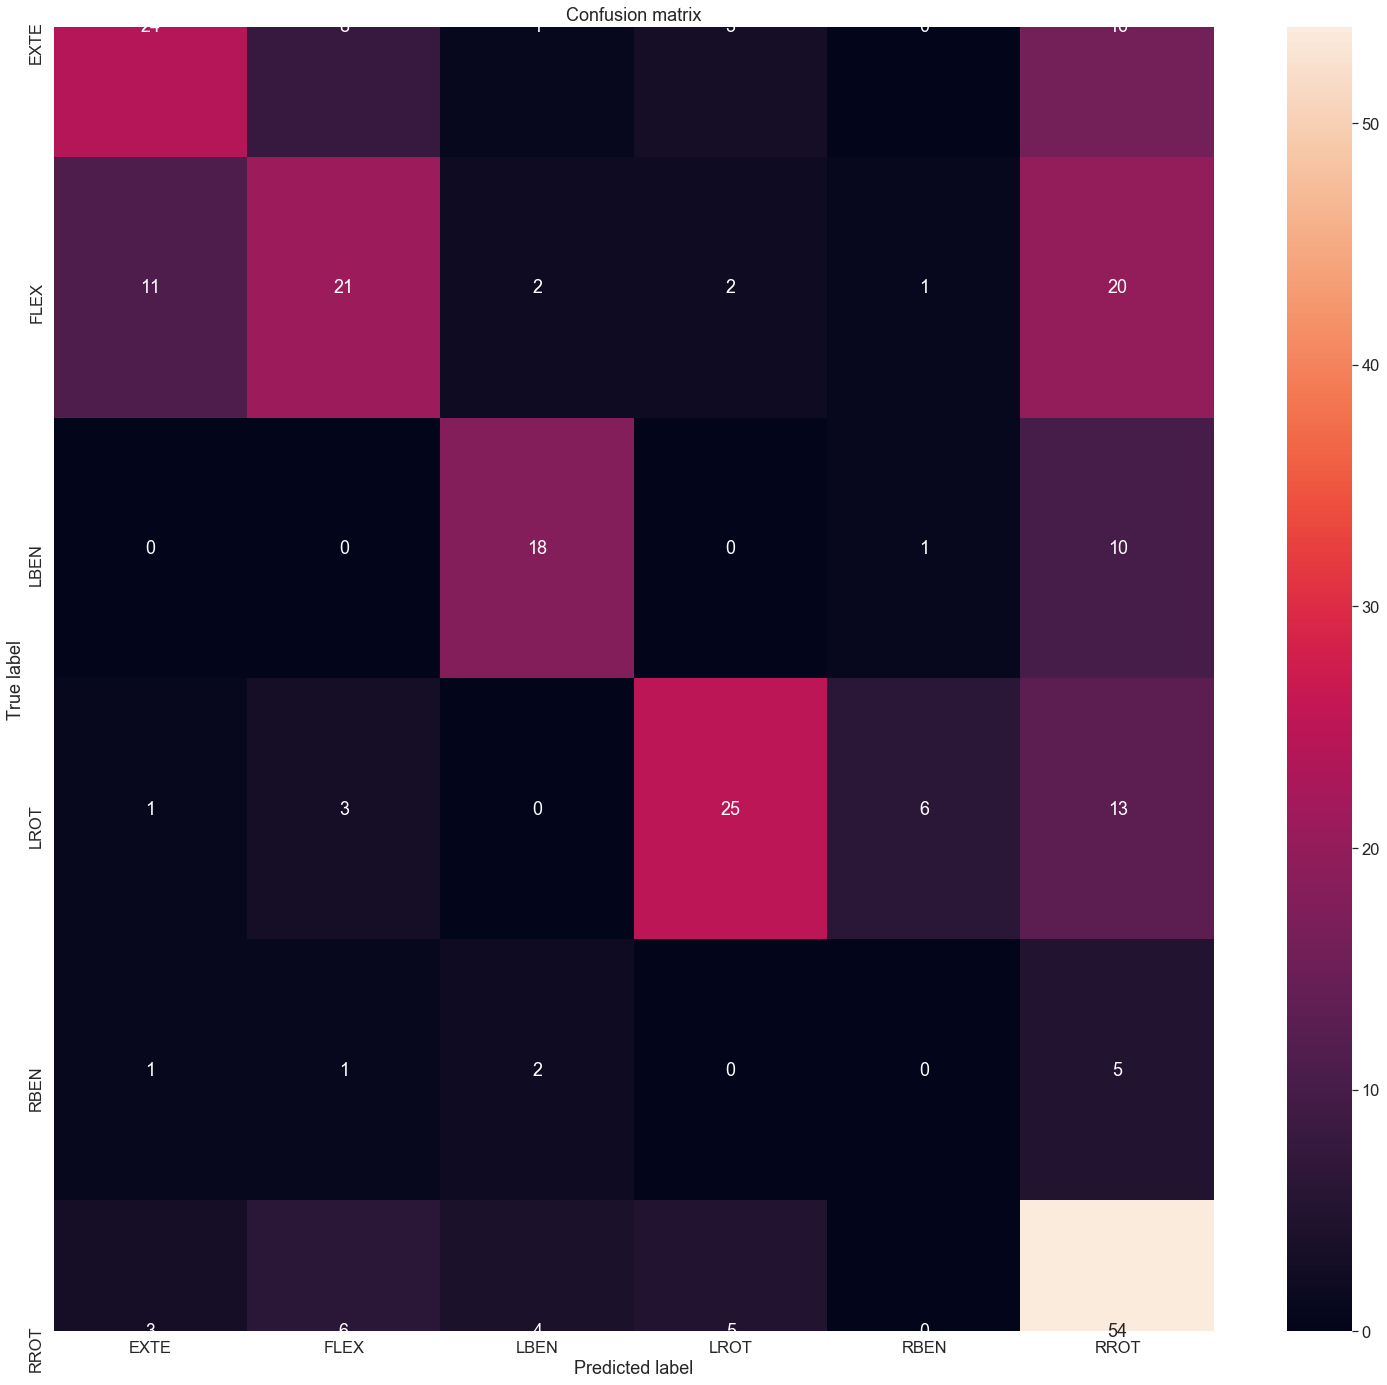

In [31]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8
LABELS = "EXTE FLEX LBEN LROT RBEN RROT".split()
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(26, 24))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.show();

plt.savefig('confusion.png')

In [25]:
labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [27]:
v_labels=[]
for i in range(0, len(df) - N_TIME_STEPS, step):
    #xs = df['head_rotx_n'].values[i: i + N_TIME_STEPS]
    #ys = df['head_roty_n'].values[i: i + N_TIME_STEPS]
    #zs = df['head_rotz_n'].values[i: i + N_TIME_STEPS]
    v_label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #segments.append([xs, ys, zs])
    v_labels.append(v_label)

In [40]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

#role = get_execution_role()
role = 'arn:aws:iam::264421419663:root'

region = sagemaker_session.boto_session.region_name

In [41]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)


In [43]:

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train)
    model.evaluate(x_test, y_test)

    return model


def _load_training_data(base_dir):
    """Load MNIST training data"""
    x_train = np.load(os.path.join(base_dir, 'train_data.npy'))
    y_train = np.load(os.path.join(base_dir, 'train_labels.npy'))
    return x_train, y_train


def _load_testing_data(base_dir):
    """Load MNIST testing data"""
    x_test = np.load(os.path.join(base_dir, 'eval_data.npy'))
    y_test = np.load(os.path.join(base_dir, 'eval_labels.npy'))
    return x_test, y_test


def _parse_args():
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))

    return parser.parse_known_args()


if __name__ == "__main__":
    args, unknown = _parse_args()

    train_data, train_labels = _load_training_data(args.train)
    eval_data, eval_labels = _load_testing_data(args.train)

    mnist_classifier = model(train_data, train_labels, eval_data, eval_labels)

    if args.current_host == args.hosts[0]:
        # save model to an S3 directory with version number '00000001'
        mnist_classifier.save(os.path.join(args.sm_model_dir, '000000001'), 'my_model.h5')

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [46]:
os.environ.get('SM_MODEL_DIR')

In [46]:
LABELS

['EXTE', 'FLEX', 'LBEN', 'LROT', 'RBEN', 'RROT']